In [1]:
#%% Modules
import numpy as np
import matplotlib.pyplot as plt

# The module cartopy is not part of the standard Python modules, and you would have to include it in your enviroment.
# there is other modules that can do similar to cartopy, feel free to use those insted if desired. 
import cartopy.crs as crs

# Other modules that can be helpfull to know off, scipy.fft are used in the functions "Gauss2Dconv_v1" and "griddata" is usefull later
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.interpolate import griddata


In [2]:
#QUESTION 2: for each observation point, compute the normal gravity acceleration using Eq(2)
#and derive the gravity anomaly using Eq(3) in units of mGal

#Statno [.] Latitude [deg] Longitude [deg] Height [m] Gravity [m/s2

#%% How to load "db.dat"
data = np.loadtxt("db.dat")

# to acces columns 
Measurements_number = data[:,0]
Latitude_deg = data[:,1]
Longitude_deg = data[:,2]
height = data[:,3]
Gravity = data[:,4]

Latitude_rad = np.deg2rad(Latitude_deg)

gamma_e = 9.7803267715 # (m/s^2) normal gravity on the equator
#phi = latitude
k = 0.001931851353 #constant related to the "gravity flattening"
e_2 = 0.00669438002290 #eccentricity of the geometrical ellipsoid

a = 6378137 # (m) ellipsoidal semi-major axis
f = 0.00335281068118 # ellipsoidal flattening
m = 3.449786003055778*10**(-15) #shit and pis

def gamma_0(Latitude_rad): # normal gravity acceleration on the surface of the ellipsoid
    return gamma_e*(1+k*np.sin(Latitude_rad)**2)/(np.sqrt(1-e_2*np.sin(Latitude_rad)**2)) 

def gamma(Latitude_rad,height): #series expansion
    
    return gamma_0(Latitude_rad)*(1-(2)/(a)*(1+f+m-2*f*np.sin(Latitude_rad)**2)*height+(3)/(a**2)*height**2)



mGal = 10**5 # (m/s^2) conversion

gamma_vals=gamma(Latitude_rad,height)

delta_g = (Gravity-gamma_vals)*(mGal)

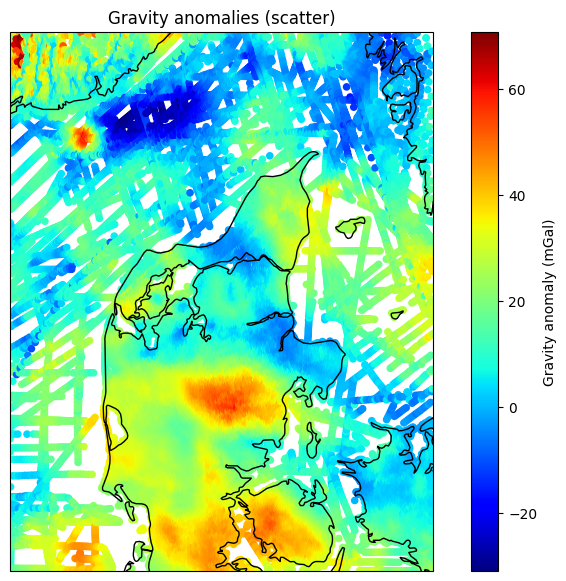

In [3]:
# extent arrays
lon_min, lon_max = np.min(Longitude_deg), np.max(Longitude_deg)
lat_min, lat_max = np.min(Latitude_deg), np.max(Latitude_deg)

latlon_area_of_interest_Q1 = [lon_min, lon_max, lat_min, lat_max]

#plot
fig, axs = plt.subplots(1, 1, figsize=(10,7),
                        subplot_kw={'projection': crs.Mercator()})

axs.coastlines()
axs.set_extent(latlon_area_of_interest_Q1, crs=crs.PlateCarree())

sc = axs.scatter(Longitude_deg, Latitude_deg,
                 c=delta_g, cmap='jet', s=20,
                 transform=crs.PlateCarree())

plt.colorbar(sc, ax=axs, label="Gravity anomaly (mGal)")
axs.set_title("Gravity anomalies (scatter)")
plt.show()
#delta_g = (Gravity-gamma_vals)*(mGal):
#in the equation the normal gravity is subtracted 
#removed::::::::::::::::::::
#Normal gravity of ellipsoid
#free-air height effect is removed
#the large global trend due to earths shape and rotation is removed.

#remains:::::::::::

#Bouguer slab correction

#Terrain/topography effects
#mountains = positive anomalies
#basins = negative anomalies

#Crustal density anomalies
#sediment thickness variations
#crust–mantle boundary (Moho) depth changes
#intrusive bodies
#fault block boundaries
#density variations within the lithosphere

#Bathymetry / seafloor depth: 
# ocean areas, negative gravity from water depth.
#if deep large negative anomaly. if shallow smaller anomaly.

#Geological structures
#appear as the broad positive/negative areas in the map.

#measurmeant "artifacts":the lines in the sea (probably planes and ships)


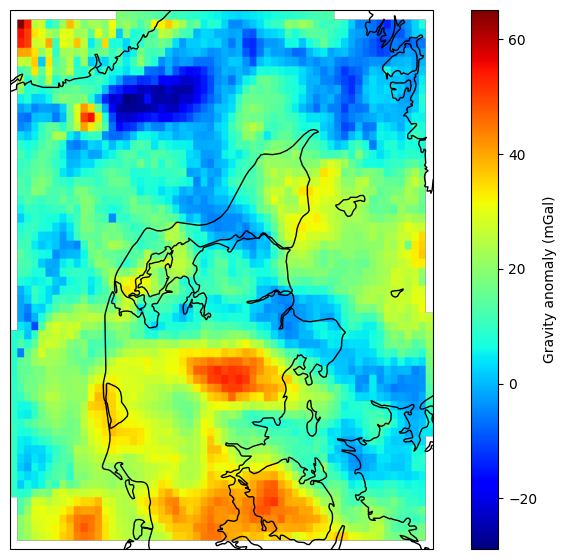

In [4]:
#question 3: 
# interpolate the scattered gravity anomalies, delta_g
#at each point. start start by forming a mesh grid with increment d_inc=1/60 (?degrees?)

grid_lon, grid_lat = np.mgrid[lon_min:lon_max:60j, lat_min:lat_max:60j]

gridded_data = griddata((Longitude_deg, Latitude_deg), delta_g, (grid_lon, grid_lat), method='linear')

fig, ax = plt.subplots(figsize=(10,7),
                       subplot_kw={'projection': crs.Mercator()})

ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs.PlateCarree())

im = ax.imshow(gridded_data.T,              # transpose fix orientation
               extent=[lon_min, lon_max, lat_min, lat_max],
               origin='lower',
               cmap='jet',
               transform=crs.PlateCarree())

#plot the grid

plt.colorbar(im, ax=ax, label="Gravity anomaly (mGal)")
axs.set_title("Gravity anomalies (scatter)")
plt.show()
#what are the benefits of using gridded data 
#for analysis and what are the disadvantages

#advantages: 
#the plot looks better and is easier to interpret 
#patterens and trends are easier to find
#smooths noise
# it makes doing calculations on the data much easier 
# many mathematical methods require regularly spaced grids

#disadvantages: 
#gridding assumes the field is continous
# you cant get exact (real) datapoints from the grided data
# sometimes the smoothing of grided data 
# is too much and you lose the reliability in areas with less datapoints.
#if you compare the 2 plots youll see that alot of the data
#in the ocean have large gaps inbetween them this is filled in by the model, 
#on the grided plot which therefor makes the datapoints less reliable (?artifacts?)

In [5]:
#Question 4: bouguer Anomalies 

#1: how do we conclude that the free-air gravity anomalies mainly originate from topography

#2: describe the bouguer plate correction

#3: compute the bouguer plate correction using EQ(4) and density p_ru=2670 kg/m^3 (argue for this density) derive the simple bouguer anomaly for all (scattered) data points using EQ(5)

#the density is the global mean density of continental crust rock

G = 6.674*10**(-11) #m^3/(kg*s^2)
rho_mean = 2670 #kg/m^3

A_b_mean = 2*np.pi*G*rho_mean*height*mGal

delta_g_b_mean = delta_g - A_b_mean

print(delta_g_b_mean)
print(A_b_mean)


[ 9.55489985 10.17453828  9.24478163 ...  0.65528243  3.69022418
 27.28323041]
[0.         0.         0.         ... 4.53005224 0.82853155 0.        ]


Text(0, 0.5, 'delta_g_b_mean (mGal)')

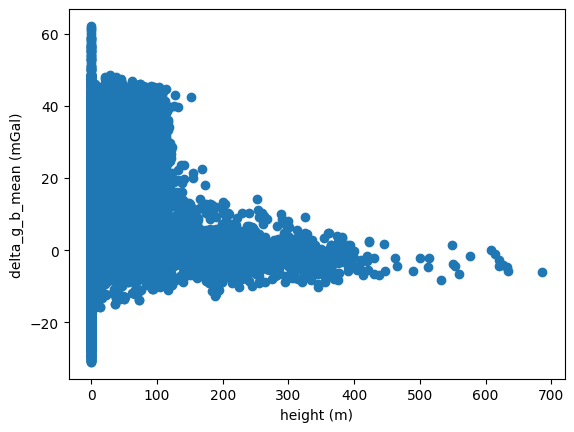

In [6]:
#Nettleton's method: if to low replacment density - bouguer gravity will show positive residual correlation with topography
#if too high - bouguer gravity will show negative

#graf ligner lort????????????????????????????????????????????????
plt.scatter(height, delta_g_b_mean,)
plt.xlabel("height (m)")
plt.ylabel("delta_g_b_mean (mGal)")

[ 9.55489985 10.17453828  9.24478163 ...  1.11337761  3.77400826
 27.28323041]
[0.         0.         0.         ... 4.53005224 0.82853155 0.        ]


Text(0, 0.5, 'A_b (mGal)')

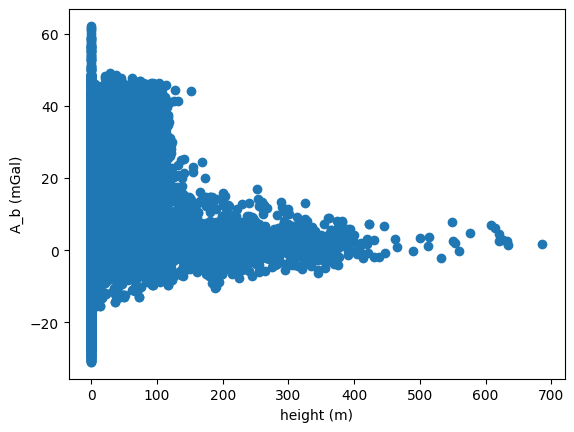

In [7]:
#4 compute the bouguer plate correction using Eq(4) and another suitable chosen density p (argue for the choice of this density); 
# derive the simple bouguer anomaly for all (scattered) data points using EQ(5)
rho_test = 2400 # denmark 

A_b_test = 2*np.pi*G*rho_test*height*mGal

delta_g_b_test = delta_g - A_b_test

print(delta_g_b_test)
print(A_b_mean)

#graf ligner lort????????????????????????????????????????????????
plt.scatter(height, delta_g_b_test,)
plt.xlabel("height (m)")
plt.ylabel("A_b (mGal)")

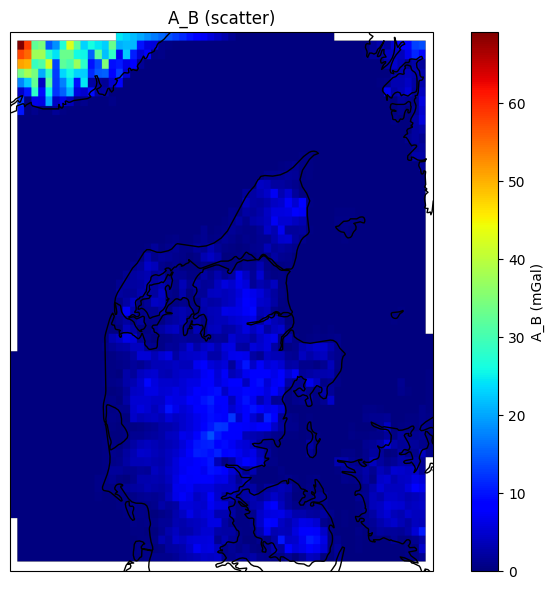

In [8]:

gridded_data_AB_mean = griddata((Longitude_deg, Latitude_deg), A_b_mean, (grid_lon, grid_lat), method='linear')


fig, ax = plt.subplots(figsize=(10,7),
                       subplot_kw={'projection': crs.Mercator()})

ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs.PlateCarree())

im = ax.imshow(gridded_data_AB_mean.T,              # transpose fix orientation
               extent=[lon_min, lon_max, lat_min, lat_max],
               origin='lower',
               cmap='jet',
               transform=crs.PlateCarree())

#plot the grid

plt.colorbar(im, ax=ax, label="A_B (mGal)")
plt.title("A_B (scatter)")
plt.show()

In [9]:
#5: grid the two bouguer anomalies as in the previous question (similar to free-air) anomalies 

gridded_data_B_mean = griddata((Longitude_deg, Latitude_deg), delta_g_b_mean, (grid_lon, grid_lat), method='linear')

gridded_data_B_test = griddata((Longitude_deg, Latitude_deg), delta_g_b_test, (grid_lon, grid_lat), method='linear')


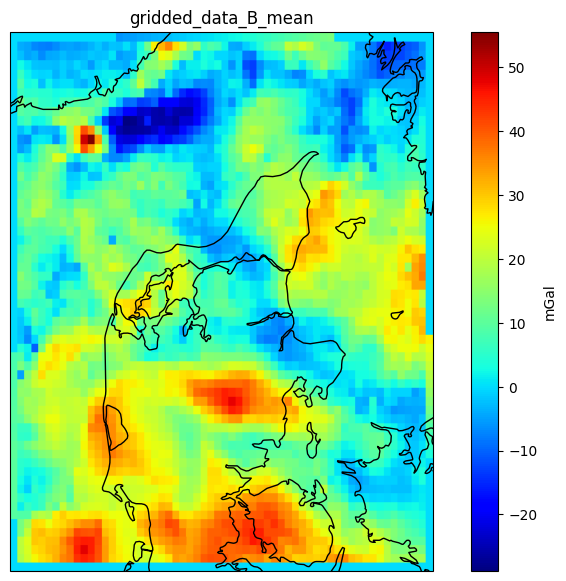

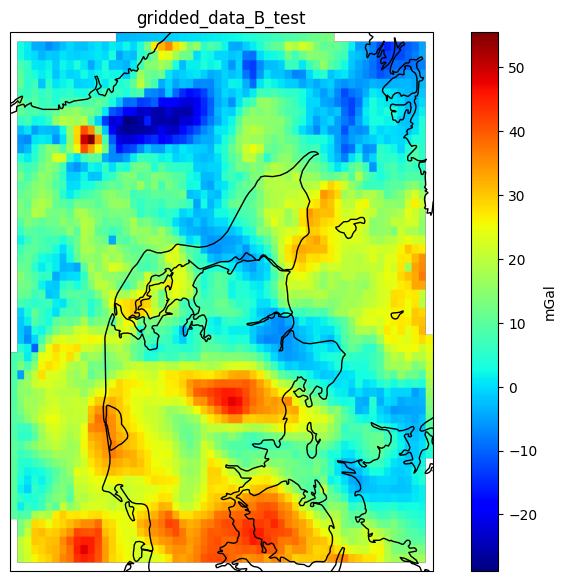

In [ ]:
#6: Image plot
fig_mean, axs_mean = plt.subplots(1,1, figsize=(10, 7), 
                        sharex=True, sharey=True,
                        subplot_kw={'projection': crs.Mercator()})

fig_test, axs_test = plt.subplots(1,1, figsize=(10, 7), 
                        sharex=True, sharey=True,
                        subplot_kw={'projection': crs.Mercator()})

axs_mean.coastlines() # add costline
axs_mean.set_extent(extents=[lon_min, lon_max, lat_min, lat_max], crs=crs.PlateCarree()) # area of interest, this is the extend we see

axs_test.coastlines() # add costline
axs_test.set_extent(extents=[lon_min, lon_max, lat_min, lat_max], crs=crs.PlateCarree()) # area of interest, this is the extend we see

im_mean = axs_mean.imshow(gridded_data_B_mean.T, 
            extent=[lon_min, lon_max, lat_min, lat_max], 
            origin='lower',
            cmap='jet',
            transform=crs.PlateCarree())

im_test = axs_test.imshow(gridded_data_B_test.T, 
            extent=[lon_min, lon_max, lat_min, lat_max], 
            origin='lower',
            cmap='jet',
            transform=crs.PlateCarree())

axs_mean.set_title('gridded_data_B_mean')
axs_test.set_title('gridded_data_B_test')

h_mean = fig_mean.colorbar(im_mean, ax=axs_mean)
h_mean.set_label('mGal')

h_test = fig_test.colorbar(im_test, ax=axs_test)
h_test.set_label('mGal')

In [13]:
#7: comment on the figures: do the look resonable? compare and explain the differences in the two bouguer data sets. 
# which sources have been removed from the signal? which sources of information remain?

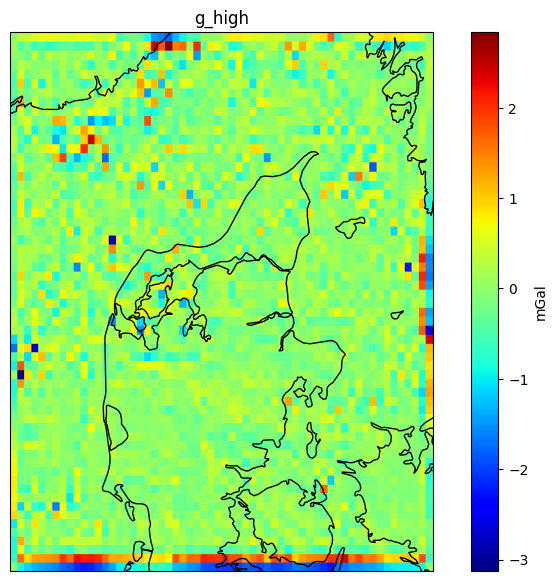

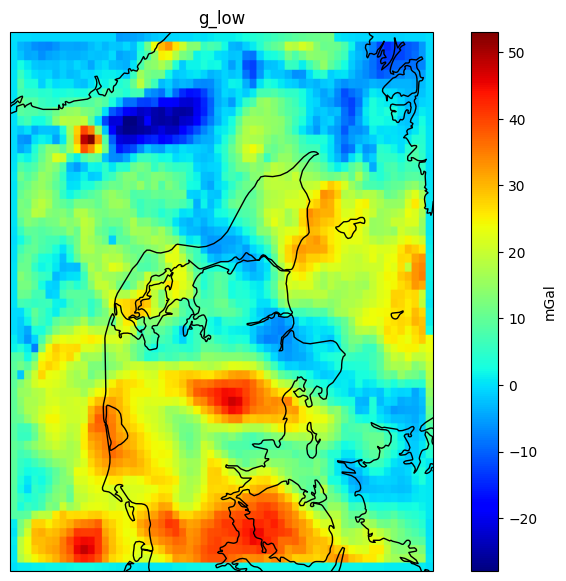

In [58]:
#question 5:spectral filtering

#1: Choose an initial value of sigma that you find reasonable. 
# Apply spectral filtering to the grid of Bouguer anomalies
import Gauss2Dconv_v1 as G
grid_lat_filter, grid_lon_filter = np.mgrid[lat_min:lat_max:60j, lon_min:lon_max:60j]

val_filter = gridded_data_B_mean

sigma_filter = 15000    # (m)

g_low, g_high = G.Gauss2Dconv_v1(grid_lon_filter, grid_lat_filter, val_filter, sigma_filter)

#2:Plot/visualize both the low- and high-wavenumber components of the signal 
#(long and short wavelength)

# Image plot
fig_high, axs_high = plt.subplots(1,1, figsize=(10, 7), 
                        sharex=True, sharey=True,
                        subplot_kw={'projection': crs.Mercator()})

fig_low, axs_low = plt.subplots(1,1, figsize=(10, 7), 
                        sharex=True, sharey=True,
                        subplot_kw={'projection': crs.Mercator()})

axs_low.coastlines() # add costline
axs_low.set_extent(extents=[lon_min, lon_max, lat_min, lat_max], crs=crs.PlateCarree()) # area of interest, this is the extend we see

axs_high.coastlines() # add costline
axs_high.set_extent(extents=[lon_min, lon_max, lat_min, lat_max], crs=crs.PlateCarree()) # area of interest, this is the extend we see

im_low = axs_low.imshow(g_low.T, 
            extent=[lon_min, lon_max, lat_min, lat_max], 
            origin='lower',
            cmap='jet',
            transform=crs.PlateCarree())

im_high = axs_high.imshow(g_high.T, 
            extent=[lon_min, lon_max, lat_min, lat_max], 
            origin='lower',
            cmap='jet',
            transform=crs.PlateCarree())

axs_low.set_title('g_low')
axs_high.set_title('g_high')

h_low = fig_low.colorbar(im_low, ax=axs_low)
h_low.set_label('mGal')

h_high = fig_high.colorbar(im_high, ax=axs_high)
h_high.set_label('mGal')